In [1]:
%matplotlib inline

import os
import urllib.request
import zipfile

from matplotlib import pylab as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
# Download USDA database

usda_db_url = 'https://www.ars.usda.gov/ARSUserFiles/80400525/Data/SR/SR28/dnload/sr28asc.zip'
if not os.path.exists('sr28asc.zip'):
    urllib.request.urlretrieve(usda_db_url, 'sr28asc.zip')
    
z = zipfile.ZipFile('sr28asc.zip', 'r')
z.extractall()
z.close()
# !ls

In [3]:
# USDA db files to csv for easy loading into pandas DF

input_files = [x for x in os.listdir() if x.endswith('.txt')]

for input_file in input_files:
    output_file = input_file.split('.')[0] + '.csv'
    with open(input_file, encoding='ascii', errors='ignore') as fin:
        with open(output_file, 'wt') as fout:
            for inline in fin:
                outline = inline.replace(',', ' ')
                outline = outline.replace('~', '').replace('^', ',')
                outline = ','.join(outline.split(','))# + '\n'
                fout.write(outline)
    
# !ls *.csv  

In [4]:
# Create the Pandas DataFrame from USDA db

# Food Description fromat details from sr28_doc.pdf page no.35

food_columns = ['NDB_No', 'FdGrp_Cd', 'Long_Desc', 'Short_Desc', 'ComName', 'ManufacName',
                'Survey', 'Ref_desc', 'Refuse', 'SciName', 
                'N_Factor', 'Pro_Factor', 'Fat_Factor', 'CHO_Factor']
food_desc = pd.read_csv('FOOD_DES.csv', names=food_columns)

# Food Group Description format from sr28_doc.pdf page no.36

food_group_columns = ['FdGrp_Cd', 'FdGrp_Desc']
food_group_names = pd.read_csv('FD_GROUP.csv', names=food_group_columns)

# Nutrient Definition format from sr28_doc.pdf page no.39

nutrients_columns = ['Nutr_No', 'Units', 'Tagname', 'NutrDesc', 'Num_Dec', 'SR_Order']
nutrients = pd.read_csv('NUTR_DEF.csv', names=nutrients_columns)

# Nutrient Data format from sr28_doc.pdf page no.37

nutrition_columns = ['NDB_No', 'Nutr_No', 'Nutr_Val', 'Num_Data_Pts', 'Std_Error',
                     'Src_Cd', 'Deriv_Cd','Ref_NDB_No', 'Add_Nutr_Mark',
                     'Num_Studies', 'Min', 'Max', 'DF', 'Low_EB', 'Up_EB', 
                     'Stat_cmt', 'AddMod_Date', 'CC']
nutrition_data = pd.read_csv('NUT_DATA.csv', names=nutrition_columns)

# Merge all tables

usda_df = pd.merge(nutrition_data, nutrients, on='Nutr_No', how='outer')
usda_df = pd.merge(usda_df, food_desc, on='NDB_No', how='outer')
usda_df = pd.merge(usda_df, food_group_names, on='FdGrp_Cd', how='outer')

# print(usda_df.columns)
print('List of all nutrients')
print(usda_df.NutrDesc.unique())

/home/srao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


List of all nutrients
['Protein' 'Total lipid (fat)' 'Carbohydrate  by difference' 'Ash' 'Energy'
 'Alcohol  ethyl' 'Water' 'Caffeine' 'Theobromine' 'Sugars  total'
 'Fiber  total dietary' 'Calcium  Ca' 'Iron  Fe' 'Magnesium  Mg'
 'Phosphorus  P' 'Potassium  K' 'Sodium  Na' 'Zinc  Zn' 'Copper  Cu'
 'Fluoride  F' 'Manganese  Mn' 'Selenium  Se' 'Vitamin A  IU' 'Retinol'
 'Vitamin A  RAE' 'Carotene  beta' 'Carotene  alpha'
 'Vitamin E (alpha-tocopherol)' 'Vitamin D' 'Vitamin D2 (ergocalciferol)'
 'Vitamin D3 (cholecalciferol)' 'Vitamin D (D2 + D3)' 'Cryptoxanthin  beta'
 'Lycopene' 'Lutein + zeaxanthin' 'Tocopherol  beta' 'Tocopherol  gamma'
 'Tocopherol  delta' 'Tocotrienol  alpha' 'Tocotrienol  beta'
 'Tocotrienol  gamma' 'Tocotrienol  delta' 'Vitamin C  total ascorbic acid'
 'Thiamin' 'Riboflavin' 'Niacin' 'Pantothenic acid' 'Vitamin B-6'
 'Folate  total' 'Vitamin B-12' 'Choline  total'
 'Vitamin K (phylloquinone)' 'Folic acid' 'Folate  food' 'Folate  DFE'
 'Betaine' 'Tryptophan' 'Thre

In [5]:
# Select the Nutrients to analyse from the above list

nutrient_to_study = 'Vitamin D'
nutrients_list = ['Vitamin D', 'Vitamin A  IU', 'Vitamin C  total ascorbic acid', 'Vitamin B-12', 
                  'Vitamin E (alpha-tocopherol)', 'Vitamin K (phylloquinone)', 'Total lipid (fat)', 'Cholesterol']

nutrients_easy_names = ['Vitamin D', 'Vitamin A',  'Vitamin C', 'Vitamin B-12', 'Vitamin E', 'Vitamin K', 
                             'Total Fats', 'Cholesterol']

df = usda_df.pivot_table(index=['FdGrp_Desc', 'Short_Desc'], columns='NutrDesc', values='Nutr_Val')
df = df[nutrients_list]

df = df.reset_index()
rename_columns = dict(zip(nutrients_list, nutrients_easy_names))
rename_columns['Short_Desc'] = 'Food Name'
rename_columns['FdGrp_Desc'] = 'Food Group'
df = df.rename(columns=rename_columns)
df.head()

NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
0,American Indian/Alaska Native Foods,ACORN STEW (APACHE),NaN,0.0,0.0,0.68,0.30,0.0,3.47,20.0
1,American Indian/Alaska Native Foods,AGAVE CKD (SOUTHWEST),0.0,113.0,0.3,0.00,0.36,4.9,0.29,0.0
2,American Indian/Alaska Native Foods,AGAVE DRIED (SOUTHWEST),0.0,18.0,0.3,0.00,0.76,0.5,0.69,0.0
3,American Indian/Alaska Native Foods,AGAVE RAW (SOUTHWEST),0.0,37.0,4.0,0.00,0.23,5.3,0.15,0.0
4,American Indian/Alaska Native Foods,AGUTUK FISH W/ SHORTENING (ALASKAN ICE CREAM) ...,NaN,257.0,NaN,NaN,4.00,NaN,43.50,26.0


In [6]:
# Find the nutrition in your favorite food
fav = df.loc[(df['Food Name'].str.contains('GUAVA'))]
fav

NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
306,Baby Foods,BABYFOOD FRUIT GUAVA&PAPAYA W/TAPIOCA STR,NaN,184.0,80.9,0.0,NaN,NaN,0.10,NaN
1229,Baked Products,PASTRY PASTELITOS DE GUAVA (GUAVA PASTRIES),NaN,NaN,NaN,NaN,0.95,12.5,18.50,10.0
2694,Beverages,BEVERAGES V8 SPLASH JUC DRINKS GUAVA PASSION F...,NaN,2058.0,24.7,NaN,1.11,NaN,0.00,NaN
4576,Fruits and Fruit Juices,GUAVA NECTAR CND W/ ADDED VIT C,NaN,106.0,21.1,NaN,0.05,1.0,0.06,0.0
4577,Fruits and Fruit Juices,GUAVA NECTAR W/ SUCRALOSE CND,0.0,49.0,21.3,0.0,0.06,1.0,0.07,0.0
4578,Fruits and Fruit Juices,GUAVA SAUCE COOKED,0.0,283.0,146.4,0.0,0.55,1.9,0.14,0.0
4579,Fruits and Fruit Juices,GUAVAS COMMON RAW,0.0,624.0,228.3,0.0,0.73,2.6,0.95,0.0
4580,Fruits and Fruit Juices,GUAVAS STRAWBERRY RAW,NaN,90.0,37.0,0.0,NaN,NaN,0.60,0.0


In [7]:
food_groups = df['Food Group'].unique()
food_groups

array(['American Indian/Alaska Native Foods', 'Baby Foods',
       'Baked Products', 'Beef Products', 'Beverages', 'Breakfast Cereals',
       'Cereal Grains and Pasta', 'Dairy and Egg Products', 'Fast Foods',
       'Fats and Oils', 'Finfish and Shellfish Products',
       'Fruits and Fruit Juices', 'Lamb  Veal  and Game Products',
       'Legumes and Legume Products', 'Meals  Entrees  and Side Dishes',
       'Nut and Seed Products', 'Pork Products', 'Poultry Products',
       'Restaurant Foods', 'Sausages and Luncheon Meats', 'Snacks',
       'Soups  Sauces  and Gravies', 'Spices and Herbs', 'Sweets',
       'Vegetables and Vegetable Products'], dtype=object)

In [8]:
# Excluding processed foods, comment out to include

df = df.loc[(df['Food Group'] != 'Baby Foods')] 
df = df.loc[(df['Food Group'] != 'Beverages')]
df = df.loc[(df['Food Group'] != 'Baked Products')]
df = df.loc[(df['Food Group'] != 'Fast Foods')]
df = df.loc[(df['Food Group'] != 'Sweets')]
df = df.loc[(df['Food Group'] != 'Snacks')]
df = df.loc[(df['Food Group'] != 'Breakfast Cereals')]
df = df.loc[(df['Food Group'] != 'Restaurant Foods')]

food_groups = df['Food Group'].unique()
food_groups

array(['American Indian/Alaska Native Foods', 'Beef Products',
       'Cereal Grains and Pasta', 'Dairy and Egg Products',
       'Fats and Oils', 'Finfish and Shellfish Products',
       'Fruits and Fruit Juices', 'Lamb  Veal  and Game Products',
       'Legumes and Legume Products', 'Meals  Entrees  and Side Dishes',
       'Nut and Seed Products', 'Pork Products', 'Poultry Products',
       'Sausages and Luncheon Meats', 'Soups  Sauces  and Gravies',
       'Spices and Herbs', 'Vegetables and Vegetable Products'], dtype=object)

In [9]:
# Excluding the artificially added stuff

added = df['Food Name'].str.contains('ADDED')
fortified = df['Food Name'].str.contains('FORT')
formula_foods = df['Food Name'].str.contains('FORMU')
suppliments = df['Food Name'].str.contains('SUPP')

exclude = df[added | fortified | formula_foods | suppliments]
df = df.loc[[x for x in df.index if x not in exclude.index]]
# df.tail()

In [10]:
# Except mushrooms, plant foods are not expected to contain any appreciable levels of vitamin D 
# (Page No.25 of sr28_doc.pdf)
# Exclude plant foods for Vitamin D may help to find correlations if any 

if nutrient_to_study == 'Vitamin D':
    df = df.loc[(df['Food Group'] != 'Vegetables and Vegetable Products')] 

if nutrient_to_study == 'Vitamin D':
    recommended_value = 500 # close to daily recommended value at https://en.wikipedia.org/wiki/Vitamin_d#Guidelines
    minimum_value = 0
    
else: 
    recommended_value = 0
    minimum_value = 0
    

r_df = df.loc[(df[nutrient_to_study] > recommended_value)].head(50) 
r_df = r_df.sort_values(nutrient_to_study, ascending=False)
print('Foods with recommended quantity of %s' % nutrient_to_study)
r_df

Foods with recommended quantity of Vitamin D


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
3938,Fats and Oils,FISH OIL COD LIVER,10000.0,100000.0,0.0,0.00,NaN,NaN,100.00,570.0
4239,Finfish and Shellfish Products,HALIBUT GREENLAND RAW,1097.0,47.0,0.0,1.00,0.73,0.1,13.84,46.0
4260,Finfish and Shellfish Products,MACKEREL SALTED,1006.0,157.0,0.0,12.00,2.38,7.8,25.10,95.0
4158,Finfish and Shellfish Products,CARP RAW,988.0,30.0,1.6,1.53,0.63,0.1,5.60,66.0
4204,Finfish and Shellfish Products,EEL MIXED SPECIES RAW,932.0,3477.0,1.8,3.00,4.00,0.0,11.66,126.0
4325,Finfish and Shellfish Products,SALMON SOCKEYE CND DRND SOL WO/ SKN & BONES,859.0,187.0,0.0,5.54,2.09,0.1,5.87,66.0
4221,Finfish and Shellfish Products,FISH SALMON SOCKEYE CND DRND SOL,841.0,184.0,0.0,5.50,2.07,0.1,7.39,79.0
4326,Finfish and Shellfish Products,SALMON SOCKEYE CND TOTAL CAN CONTENTS,761.0,129.0,0.0,0.40,1.88,0.1,7.17,67.0
4374,Finfish and Shellfish Products,TROUT RAINBOW FARMED CKD DRY HEAT,759.0,301.0,2.9,4.11,2.79,0.1,7.38,70.0
4311,Finfish and Shellfish Products,SALMON CHINOOK SMOKED,685.0,87.0,0.0,3.26,1.35,0.1,4.32,23.0


In [11]:
corr = r_df.corr()
corr

NutrDesc,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
NutrDesc,,,,,,,,
Vitamin D,1.000000,0.995666,-0.083759,-0.214429,0.379363,0.285377,0.974760,0.932729
Vitamin A,0.995666,1.000000,-0.084065,-0.216695,0.402037,-0.100145,0.967794,0.935351
Vitamin C,-0.083759,-0.084065,1.000000,-0.127384,0.314311,-0.102931,-0.056942,-0.081741
Vitamin B-12,-0.214429,-0.216695,-0.127384,1.000000,0.256807,0.384156,-0.131443,0.068086
Vitamin E,0.379363,0.402037,0.314311,0.256807,1.000000,0.140134,0.330203,0.507145
Vitamin K,0.285377,-0.100145,-0.102931,0.384156,0.140134,1.000000,0.765838,0.081368
Total Fats,0.974760,0.967794,-0.056942,-0.131443,0.330203,0.765838,1.000000,0.918835
Cholesterol,0.932729,0.935351,-0.081741,0.068086,0.507145,0.081368,0.918835,1.000000


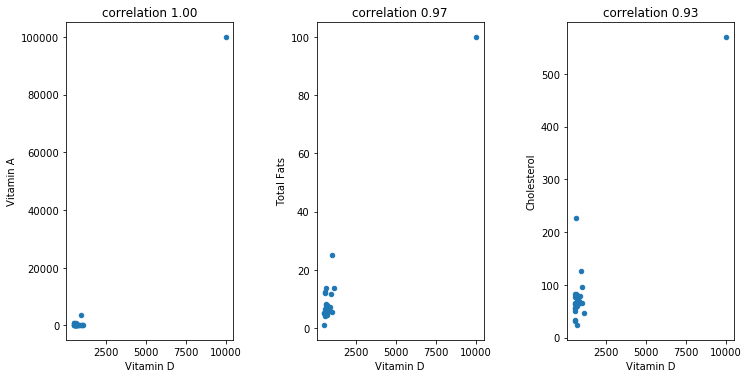

In [12]:
good_corr = corr[corr[nutrient_to_study] > .5][nutrient_to_study]
good_corr = good_corr[good_corr.index != nutrient_to_study]
plots = len(good_corr.index)
if plots > 1:
    fig, axs = plt.subplots(1,plots)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    for i in range(plots):
        r_df.plot.scatter(nutrient_to_study, good_corr.index[i], ax=axs[i])
        axs[i].set_title('correlation %.2f' % good_corr[i])
elif plots == 1:
    r_df.plot.scatter(nutrient_to_study, good_corr.index[0])
    plt.title('correlation %.2f' % good_corr[0])
# good_corr

In [13]:
no_outlier = r_df.tail(len(r_df)-1)
corr = no_outlier.corr()
corr

NutrDesc,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
NutrDesc,,,,,,,,
Vitamin D,1.000000,0.170605,0.082873,-0.022707,0.379363,0.285377,0.502271,0.123745
Vitamin A,0.170605,1.000000,0.218957,-0.103105,0.402037,-0.100145,0.145512,0.263380
Vitamin C,0.082873,0.218957,1.000000,-0.151057,0.314311,-0.102931,0.125555,0.010699
Vitamin B-12,-0.022707,-0.103105,-0.151057,1.000000,0.256807,0.384156,0.301030,0.757159
Vitamin E,0.379363,0.402037,0.314311,0.256807,1.000000,0.140134,0.330203,0.507145
Vitamin K,0.285377,-0.100145,-0.102931,0.384156,0.140134,1.000000,0.765838,0.081368
Total Fats,0.502271,0.145512,0.125555,0.301030,0.330203,0.765838,1.000000,0.184423
Cholesterol,0.123745,0.263380,0.010699,0.757159,0.507145,0.081368,0.184423,1.000000


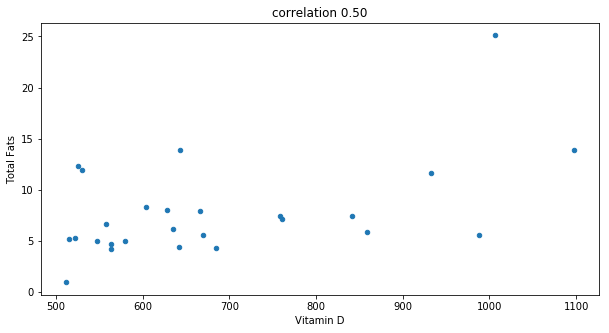

In [14]:
good_corr = corr[corr[nutrient_to_study] > .5][nutrient_to_study]
good_corr = good_corr[good_corr.index != nutrient_to_study]
plots = len(good_corr.index)

if plots > 1:
    fig, axs = plt.subplots(1,plots)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    for i in range(plots):
        print(i, good_corr.index[i], good_corr[i])
        no_outlier.plot.scatter(nutrient_to_study, good_corr.index[i], ax=axs[i])
        axs[i].set_title('correlation %.2f' % good_corr[i])
elif plots == 1:
    no_outlier.plot.scatter(nutrient_to_study, good_corr.index[0])
    plt.title('correlation %.2f' % good_corr[0])

In [15]:
df = df.loc[(df[nutrient_to_study] > minimum_value)]

In [16]:
food_groups = list(df['Food Group'].unique())
print (food_groups)
topn = 10

['American Indian/Alaska Native Foods', 'Beef Products', 'Cereal Grains and Pasta', 'Dairy and Egg Products', 'Fats and Oils', 'Finfish and Shellfish Products', 'Fruits and Fruit Juices', 'Lamb  Veal  and Game Products', 'Legumes and Legume Products', 'Meals  Entrees  and Side Dishes', 'Pork Products', 'Poultry Products', 'Sausages and Luncheon Meats', 'Soups  Sauces  and Gravies']


In [17]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[0]))
df.loc[(df['Food Group'] == food_groups[0])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "American Indian/Alaska Native Foods"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
134,American Indian/Alaska Native Foods,STEELHEAD TROUT DRIED FLESH (SHOSHONE BANNOCK),628.0,213.0,0.0,22.40,2.41,0.0,8.06,227.0
133,American Indian/Alaska Native Foods,STEELHEAD TROUT BLD CND (ALASKA NATIVE),604.0,65.0,0.0,5.79,2.15,0.0,8.26,59.0
95,American Indian/Alaska Native Foods,OIL BELUGA WHALE (ALASKA NATIVE),228.0,2310.0,NaN,0.00,8.27,0.0,100.00,NaN
69,American Indian/Alaska Native Foods,FISH SALMON RED (SOCKEYE) KIPPERED (ALASKA NAT...,80.0,50.0,0.0,4.98,0.44,0.0,4.75,68.0
67,American Indian/Alaska Native Foods,FISH SALMON KING W/ SKN KIPPERED (ALASKA NATIVE),46.0,41.0,0.0,3.65,0.42,0.0,12.95,67.0
94,American Indian/Alaska Native Foods,OIL BEARDED SEAL (OOGRUK) (ALASKA NATIVE),30.0,33.0,0.0,0.00,10.28,0.0,99.60,52.0
96,American Indian/Alaska Native Foods,OIL SPOTTED SEAL (ALASKA NATIVE),30.0,3480.0,0.0,0.00,6.28,0.0,99.32,NaN
118,American Indian/Alaska Native Foods,SEA LION STELLER MEAT (ALASKA NATIVE),1.0,NaN,0.0,NaN,NaN,NaN,1.88,64.0


In [18]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[1]))
df.loc[(df['Food Group'] == food_groups[1])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Beef Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
2318,Beef Products,BEEF VAR MEATS&BY-PRODUCTS LIVER RAW,49.0,16898.0,1.3,59.30,0.38,3.1,3.63,275.0
2308,Beef Products,BEEF VAR MEATS & BY-PRODUCTS LIVER CKD BRSD,49.0,31714.0,1.9,70.58,0.51,3.3,5.26,396.0
1411,Beef Products,BEEF VAR MEATS&BY-PRODUCTS LIVER CKD PAN-F...,49.0,26088.0,0.7,83.13,0.46,3.9,4.68,381.0
2317,Beef Products,BEEF VAR MEATS&BY-PRODUCTS KIDNEYS RAW,45.0,1397.0,9.4,27.50,0.22,0.0,3.09,411.0
2316,Beef Products,BEEF VAR MEATS&BY-PRODUCTS KIDNEYS CKD SIMMRD,45.0,0.0,0.0,24.90,0.08,0.0,4.65,716.0
1855,Beef Products,BEEF NZ IMP VAR MEATS & BY-PRODUCTS KIDNEY CKD...,33.0,347.0,0.0,21.35,1.53,NaN,5.27,1002.0
1976,Beef Products,BEEF RIB SHORTRIBS LN&FAT CHOIC CKD BRSD,27.0,0.0,0.0,2.62,0.29,2.4,41.98,94.0
1848,Beef Products,BEEF NZ IMP SWEETBREAD RAW,25.0,65.0,0.0,2.10,0.69,NaN,28.60,217.0
1847,Beef Products,BEEF NZ IMP SWEETBREAD CKD BLD,22.0,62.0,0.0,1.50,0.79,NaN,29.79,249.0
2006,Beef Products,"BEEF RIB WHL (RIBS 6-12) LN&FAT 1/8""FAT CHOIC ...",19.0,0.0,0.0,2.55,0.24,2.0,29.79,84.0


In [19]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[2]))
df.loc[(df['Food Group'] == food_groups[2])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Cereal Grains and Pasta"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
3146,Cereal Grains and Pasta,NOODLES EGG DRY ENRICHED,11.0,62.0,0.0,0.29,0.37,0.5,4.44,84.0
3147,Cereal Grains and Pasta,NOODLES EGG DRY UNENR,11.0,62.0,0.0,0.29,0.37,0.5,4.44,84.0
3148,Cereal Grains and Pasta,NOODLES EGG ENR CKD,4.0,21.0,0.0,0.09,0.17,0.0,2.07,29.0
3149,Cereal Grains and Pasta,NOODLES EGG SPINACH ENR CKD,4.0,103.0,0.0,0.14,0.55,101.1,1.57,33.0


In [20]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[3]))
df.loc[(df['Food Group'] == food_groups[3])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Dairy and Egg Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
3425,Dairy and Egg Products,EGG YOLK DRIED,417.0,1590.0,0.0,5.11,4.81,1.5,59.13,2307.0
3419,Dairy and Egg Products,EGG WHL DRIED,331.0,999.0,0.0,2.96,3.88,1.2,43.90,1630.0
3404,Dairy and Egg Products,EGG MIX USDA CMDTY,296.0,398.0,NaN,2.90,2.04,0.7,34.50,975.0
3427,Dairy and Egg Products,EGG YOLK RAW FRZ PAST,238.0,1469.0,0.0,1.90,2.24,0.7,25.60,991.0
3426,Dairy and Egg Products,EGG YOLK RAW FRSH,218.0,1442.0,0.0,1.95,2.58,0.7,26.54,1085.0
3472,Dairy and Egg Products,MILK CND EVAP WO/ VIT A,160.0,192.0,16.0,0.16,0.18,0.2,2.00,0.0
3428,Dairy and Egg Products,EGG YOLK RAW FRZ SALTED PAST,126.0,1043.0,0.0,1.61,2.28,0.7,22.93,912.0
3429,Dairy and Egg Products,EGG YOLK RAW FRZ SUGARED PAST,123.0,1103.0,0.0,1.64,2.25,0.7,22.82,917.0
3319,Dairy and Egg Products,CHEESE FRSH QUESO FRESCO,110.0,806.0,0.0,1.68,0.37,1.0,23.82,69.0
3422,Dairy and Egg Products,EGG WHL RAW FRZ PAST,105.0,570.0,0.0,1.00,0.72,0.3,9.95,372.0


In [21]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[4]))
df.loc[(df['Food Group'] == food_groups[4])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Fats and Oils"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
3938,Fats and Oils,FISH OIL COD LIVER,10000.0,100000.0,0.0,0.0,NaN,NaN,100.00,570.0
4136,Fats and Oils,VEG OIL SPRD 60% FAT STICK/TUB/BOTTLE WO/ SALT...,429.0,3577.0,0.1,10.8,21.12,101.3,59.81,1.0
3943,Fats and Oils,FISH OIL SARDINE,332.0,0.0,0.0,0.0,NaN,NaN,100.00,710.0
3933,Fats and Oils,FAT CHICKEN,191.0,0.0,0.0,0.0,2.70,0.0,99.80,85.0
3934,Fats and Oils,FAT DUCK,191.0,0.0,0.0,0.0,2.70,0.0,99.80,100.0
3937,Fats and Oils,FAT TURKEY,191.0,0.0,0.0,0.0,2.90,0.0,99.80,102.0
3944,Fats and Oils,LARD,102.0,0.0,0.0,0.0,0.60,0.0,100.00,95.0
3924,Fats and Oils,ANIMAL FAT BACON GREASE,101.0,0.0,0.0,0.0,0.60,0.0,99.50,95.0
3986,Fats and Oils,MEAT DRIPPINGS (LARD BF TALLOW MUTTON TALLOW),100.0,0.0,0.0,0.0,0.59,0.0,98.59,101.0
3936,Fats and Oils,FAT MUTTON TALLOW,28.0,0.0,0.0,0.0,2.80,0.0,100.00,102.0


In [22]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[5]))
df.loc[(df['Food Group'] == food_groups[5])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Finfish and Shellfish Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
4239,Finfish and Shellfish Products,HALIBUT GREENLAND RAW,1097.0,47.0,0.0,1.00,0.73,0.1,13.84,46.0
4260,Finfish and Shellfish Products,MACKEREL SALTED,1006.0,157.0,0.0,12.00,2.38,7.8,25.10,95.0
4158,Finfish and Shellfish Products,CARP RAW,988.0,30.0,1.6,1.53,0.63,0.1,5.60,66.0
4204,Finfish and Shellfish Products,EEL MIXED SPECIES RAW,932.0,3477.0,1.8,3.00,4.00,0.0,11.66,126.0
4325,Finfish and Shellfish Products,SALMON SOCKEYE CND DRND SOL WO/ SKN & BONES,859.0,187.0,0.0,5.54,2.09,0.1,5.87,66.0
4221,Finfish and Shellfish Products,FISH SALMON SOCKEYE CND DRND SOL,841.0,184.0,0.0,5.50,2.07,0.1,7.39,79.0
4326,Finfish and Shellfish Products,SALMON SOCKEYE CND TOTAL CAN CONTENTS,761.0,129.0,0.0,0.40,1.88,0.1,7.17,67.0
4374,Finfish and Shellfish Products,TROUT RAINBOW FARMED CKD DRY HEAT,759.0,301.0,2.9,4.11,2.79,0.1,7.38,70.0
4311,Finfish and Shellfish Products,SALMON CHINOOK SMOKED,685.0,87.0,0.0,3.26,1.35,0.1,4.32,23.0
4220,Finfish and Shellfish Products,FISH SALMON SOCKEYE CKD DRY HEAT,670.0,193.0,0.0,4.47,0.99,0.1,5.57,61.0


In [23]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[6]))
df.loc[(df['Food Group'] == food_groups[6])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Fruits and Fruit Juices"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
4629,Fruits and Fruit Juices,ORANGE JUC CHILLED INCL FROM CONC W/ ADD CA & ...,42.0,417.0,33.6,0.0,1.13,0.0,0.12,0.0


In [24]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[7]))
df.loc[(df['Food Group'] == food_groups[7])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Lamb  Veal  and Game Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
5146,Lamb Veal and Game Products,VEAL EXTERNAL FAT ONLY RAW,220.0,0.0,0.0,1.35,0.30,2.8,51.60,86.0
5178,Lamb Veal and Game Products,VEAL SEAM FAT ONLY CKD,181.0,0.0,0.0,1.62,0.52,2.4,50.17,82.0
5145,Lamb Veal and Game Products,VEAL EXTERNAL FAT ONLY CKD,142.0,0.0,0.0,1.61,0.45,2.4,53.23,85.0
5179,Lamb Veal and Game Products,VEAL SEAM FAT ONLY RAW,142.0,0.0,0.0,1.56,0.68,2.5,43.75,83.0
5171,Lamb Veal and Game Products,VEAL LOIN LN&FAT RAW,69.0,0.0,0.0,2.46,0.30,1.3,10.07,59.0
5193,Lamb Veal and Game Products,VEAL SHLDR BLADE CHOP LN & FAT RAW,60.0,0.0,0.0,2.73,0.30,1.2,7.61,62.0
5150,Lamb Veal and Game Products,VEAL GROUND CKD PAN-FRIED,55.0,0.0,0.0,3.53,0.26,1.5,11.78,77.0
5192,Lamb Veal and Game Products,VEAL SHLDR BLADE CHOP LN & FAT CKD GRILLED,54.0,0.0,0.0,3.44,0.47,1.4,10.57,78.0
5151,Lamb Veal and Game Products,VEAL GROUND RAW,51.0,0.0,0.0,2.28,0.49,1.4,13.06,49.0
5168,Lamb Veal and Game Products,VEAL LOIN LN RAW,48.0,0.0,0.0,2.65,0.27,1.1,2.90,55.0


In [25]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[8]))
df.loc[(df['Food Group'] == food_groups[8])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Legumes and Legume Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
5564,Legumes and Legume Products,VITASOY USA NASOYA LITE FIRM TOFU,157.0,1902.0,NaN,2.36,5.22,NaN,1.70,0.0
5565,Legumes and Legume Products,VITASOY USA NASOYA LITE SILKEN TOFU,153.0,1913.0,NaN,2.42,5.26,NaN,1.10,0.0
5572,Legumes and Legume Products,VITASOY USA ORGANIC NASOYA TOFU PLUS FIRM,101.0,NaN,NaN,1.43,NaN,NaN,3.40,0.0
5571,Legumes and Legume Products,VITASOY USA ORGANIC NASOYA TOFU PLUS EX FIRM,101.0,NaN,NaN,1.45,NaN,NaN,4.90,0.0
5569,Legumes and Legume Products,VITASOY USA ORGANIC NASOYA SPROUTED TOFU PLUS ...,98.0,NaN,NaN,NaN,NaN,14.7,5.90,0.0
5503,Legumes and Legume Products,SILK VANILLA SOY YOGURT (FAMILY SIZE),53.0,NaN,0.0,NaN,NaN,NaN,1.76,0.0
5495,Legumes and Legume Products,SILK PLN SOY YOGURT,53.0,0.0,13.2,NaN,NaN,NaN,1.76,0.0
5498,Legumes and Legume Products,SILK PLUS FOR BONE HEALTH SOYMILK,49.0,206.0,0.0,1.23,NaN,NaN,1.44,0.0
5497,Legumes and Legume Products,SILK PLUS FIBER SOYMILK,49.0,206.0,0.0,1.23,NaN,NaN,1.44,0.0
5505,Legumes and Legume Products,SILK VANILLA SOYMILK,49.0,206.0,0.0,1.23,NaN,NaN,1.44,0.0


In [26]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[9]))
df.loc[(df['Food Group'] == food_groups[9])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Meals  Entrees  and Side Dishes"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
5629,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS SPAGHETTIOS PLUS CA,40.0,198.0,1.0,0.00,0.00,NaN,0.40,2.0
5711,Meals Entrees and Side Dishes,SAUSAGE EGG & CHS BRKFST BISCUIT,27.0,632.0,0.1,0.59,1.56,1.8,22.13,78.0
5630,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS W/ MEATBALLS -,19.0,243.0,2.9,0.00,0.00,NaN,2.43,10.0
5623,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS RAVIOLIOS BF RAVIOLI IN...,16.0,119.0,0.0,NaN,NaN,NaN,3.17,8.0
5715,Meals Entrees and Side Dishes,SPAGHETTIOS SPAGHETTIOS W/ SLICED FRANKS,16.0,198.0,2.4,0.00,0.00,NaN,2.38,8.0
5693,Meals Entrees and Side Dishes,PASTA W/SLICED FRANKS IN TOMATO SAU CND ENTREE,16.0,198.0,3.8,0.19,0.74,1.6,2.38,9.0
5714,Meals Entrees and Side Dishes,SPAGHETTIOS SPAGHETTIOS W/ MEATBALLS,16.0,198.0,2.4,0.00,NaN,NaN,2.78,8.0
5627,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS SPAGHETTIOS IN MEAT SAU,16.0,397.0,0.0,NaN,NaN,NaN,0.79,4.0
5626,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS SPAGHETTIOS A TO Z'S W/...,16.0,198.0,2.4,0.00,0.00,NaN,2.78,8.0
5625,Meals Entrees and Side Dishes,CAMPBELL'S SPAGHETTIOS SPAGHETTIOS A TO Z'S,16.0,198.0,1.0,0.00,0.00,NaN,0.40,2.0


In [27]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[10]))
df.loc[(df['Food Group'] == food_groups[10])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Pork Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
5991,Pork Products,PORK FRESH BACKFAT RAW,122.0,15.0,0.1,0.18,0.00,0.0,88.69,57.0
6159,Pork Products,PORK FRSH SPARERIBS LN&FAT CKD BRSD,104.0,10.0,0.0,1.08,0.34,0.0,30.30,121.0
5941,Pork Products,PORK CURED HAM EX LN (APPROX 4% FAT) CND UNHTD,93.0,0.0,0.0,0.82,0.17,0.0,4.56,38.0
6160,Pork Products,PORK FRSH SPARERIBS LN&FAT RAW,91.0,0.0,0.0,0.38,0.37,0.0,23.40,80.0
6158,Pork Products,PORK FRSH SPARERIBS LN & FAT CKD RSTD,88.0,0.0,0.0,0.45,0.14,0.0,30.86,105.0
5944,Pork Products,PORK CURED HAM FAT BNLESS HTD,75.0,42.0,0.0,0.31,0.35,NaN,51.57,72.0
6082,Pork Products,PORK FRSH LOIN COUNTRY-STYLE RIBS LN & FAT BON...,72.0,8.0,0.3,0.76,0.00,0.0,29.46,91.0
6011,Pork Products,PORK FRSH FAT CKD,72.0,80.0,0.0,0.54,0.00,0.0,66.10,79.0
6157,Pork Products,PORK FRSH SHLDR WHL LN&FAT RAW,70.0,7.0,0.7,0.74,0.19,0.0,17.99,71.0
6012,Pork Products,PORK FRSH FAT RAW,69.0,86.0,0.0,0.67,0.42,0.0,65.70,72.0


In [28]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[11]))
df.loc[(df['Food Group'] == food_groups[11])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Poultry Products"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
6279,Poultry Products,CHICKEN BROILERS OR FRYERS FAT RAW,130.0,509.0,0.0,0.07,2.73,2.4,67.95,58.0
6573,Poultry Products,TURKEY SKN FROM WHL (LIGHT & DARK) RSTD,54.0,262.0,0.0,1.71,0.15,0.0,39.31,177.0
6546,Poultry Products,TURKEY LIVER ALL CLASSES RAW,50.0,26901.0,24.5,19.73,0.24,0.0,5.50,415.0
6572,Poultry Products,TURKEY SKN FROM WHL (LIGHT & DARK) RAW,46.0,284.0,0.0,0.88,0.09,0.0,38.93,122.0
6566,Poultry Products,TURKEY RTL PARTS WING MEAT & SKN CKD RSTD,34.0,80.0,0.0,1.36,0.17,0.0,13.29,115.0
6583,Poultry Products,TURKEY WHL GIBLETS RAW,34.0,13129.0,0.0,13.06,0.25,0.0,5.09,333.0
6570,Poultry Products,TURKEY SKN FROM RTL PARTS FROM DK MEAT CKD RSTD,31.0,198.0,0.0,1.85,0.13,0.0,35.03,139.0
6571,Poultry Products,TURKEY SKN FROM RTL PARTS FROM DK MEAT RAW,30.0,263.0,0.0,1.95,0.08,0.0,35.83,111.0
6568,Poultry Products,TURKEY RTL PARTS WING MEAT ONLY CKD RSTD,28.0,25.0,0.0,1.25,0.17,0.0,5.51,97.0
6425,Poultry Products,DUCK DOMESTICATED MEAT&SKN RAW,26.0,168.0,2.8,0.25,0.70,5.5,39.34,76.0


In [29]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[12]))
df.loc[(df['Food Group'] == food_groups[12])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Sausages and Luncheon Meats"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
6879,Sausages and Luncheon Meats,TURKEY&PORK SAUSAGE FRSH BULK PATTY OR LINK CKD,79.0,0.0,1.1,1.26,0.39,5.7,23.00,84.0
6810,Sausages and Luncheon Meats,OSCAR MAYER SALAMI (HARD),62.0,44.0,0.0,1.88,NaN,NaN,28.70,97.0
6755,Sausages and Luncheon Meats,CHORIZO PORK AND BEEF,61.0,0.0,0.0,2.00,0.22,1.6,38.27,88.0
6829,Sausages and Luncheon Meats,PORK SAUSAGE LINK/PATTY RED FAT CKD PAN-FRIED,58.0,93.0,0.0,1.16,1.22,0.0,20.32,82.0
6826,Sausages and Luncheon Meats,PORK SAUSAGE LINK/PATTY CKD PAN-FRIED,58.0,93.0,0.0,0.98,0.90,0.0,27.25,86.0
6831,Sausages and Luncheon Meats,PORK SAUSAGE LINK/PATTY UNPREP,57.0,92.0,0.0,0.92,0.99,0.3,24.80,70.0
6742,Sausages and Luncheon Meats,BOLOGNA PORK,56.0,0.0,0.0,0.93,0.26,0.3,19.87,59.0
6821,Sausages and Luncheon Meats,PEPPERONI BF & PORK SLICED,52.0,0.0,0.0,1.30,1.03,5.8,46.28,97.0
6729,Sausages and Luncheon Meats,BLOOD SAUSAGE,52.0,0.0,0.0,1.00,0.13,0.0,34.50,120.0
6869,Sausages and Luncheon Meats,TURKEY BACON MICROWAVED,50.0,63.0,0.0,1.88,0.14,0.0,25.87,153.0


In [30]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[13]))
df.loc[(df['Food Group'] == food_groups[13])].sort_values(nutrient_to_study, ascending=False).head(topn)

Top 10 foods of Vitamin D in food group "Soups  Sauces  and Gravies"


NutrDesc,Food Group,Food Name,Vitamin D,Vitamin A,Vitamin C,Vitamin B-12,Vitamin E,Vitamin K,Total Fats,Cholesterol
7304,Soups Sauces and Gravies,SAUCE HOMEMADE WHITE THIN,49.0,262.0,0.8,0.30,0.17,0.6,6.73,8.0
7302,Soups Sauces and Gravies,SAUCE HOMEMADE WHITE MED,48.0,377.0,0.8,0.28,0.29,0.9,10.63,7.0
7303,Soups Sauces and Gravies,SAUCE HOMEMADE WHITE THICK,47.0,469.0,0.7,0.26,0.38,1.2,13.83,6.0
7435,Soups Sauces and Gravies,SOUP CRM OF MUSHROOM CND PREP W/ EQ VOLUME LOF...,29.0,102.0,0.1,0.28,0.26,9.6,3.58,4.0
7415,Soups Sauces and Gravies,SOUP CLAM CHOWDER NEW ENG CND PREP W/ EQ VLM L...,25.0,127.0,2.1,4.84,0.22,0.5,2.02,7.0
7445,Soups Sauces and Gravies,SOUP CRM OF SHRIMP CND PREP W/ EQ VOLUME LOFAT...,25.0,147.0,0.1,0.50,0.02,0.1,3.23,10.0
7497,Soups Sauces and Gravies,SOUP TOMATO CND PREP W/ EQ VOLUME LOFAT (2%) MILK,25.0,287.0,6.3,0.28,0.18,1.6,1.24,4.0
7305,Soups Sauces and Gravies,SAUCE HORSERADISH,10.0,66.0,0.2,0.09,4.19,90.9,50.89,50.0
7112,Soups Sauces and Gravies,CAMPBELL'S CRM OF MUSHROOM SOUP COND,9.0,8.0,0.5,NaN,0.58,22.5,5.50,0.0
7432,Soups Sauces and Gravies,SOUP CRM OF MUSHROOM CND COND,9.0,8.0,0.0,0.00,0.50,19.6,5.30,0.0


In [31]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[14]))
df.loc[(df['Food Group'] == food_groups[14])].sort_values(nutrient_to_study, ascending=False).head(topn)

IndexError: list index out of range

In [ ]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[15]))
df.loc[(df['Food Group'] == food_groups[15])].sort_values(nutrient_to_study, ascending=False).head(topn)

In [ ]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[16]))
df.loc[(df['Food Group'] == food_groups[16])].sort_values(nutrient_to_study, ascending=False).head(topn)

In [ ]:
print('Top %s foods of %s in food group "%s"' % (topn, nutrient_to_study, food_groups[17]))
df.loc[(df['Food Group'] == food_groups[17])].sort_values(nutrient_to_study, ascending=False).head(topn)